In [25]:
import os
import sys; sys.path.append("~/HHbbgg_ETH_devel/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import preprocessing_utils as preprocessing
reload(preprocessing)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt

In [23]:
clf_trainings = []
plot_classifier_all = []
fpr_dipho_all,tpr_dipho_all = [],[]
fpr_gJets_all,tpr_gJets_all = [],[]
X_total_test_all,y_total_test_all,w_total_test_all = [],[],[]
labels=[]

In [20]:
outstr = "15_10_2018_CSV_comparison"
labels.append(outstr)
utils.IO.plotFolder = '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/%s/'%outstr
if not os.path.exists(utils.IO.plotFolder):
    print utils.IO.plotFolder, "doesn't exist, creating it..."
    os.makedirs(utils.IO.plotFolder)

In [26]:
#ntuples = 'deepCSV_01_10_2018'
ntuples = 'ntuples_newcode_20180627'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n

signal = [s for s in files if "SM_plus_nodes" in s ]
diphotonJets = [s for s in files if "DiPhotonJetsBox_" in s]

gJets_lowPt = [s for s in files if "GJet_Pt-20to40" in s]
gJets_highPt = [s for s in files if "GJet_Pt-40" in s]
ggH = [s for s in files if "GluGluHToGG_M-125" in s]
ttH = [s for s in files if "ttHToGG_M125" in s]

utils.IO.add_signal(ntuples,signal,1,'nodesCombined')
utils.IO.add_background(ntuples,diphotonJets,-1,'tagsDumper/trees/DiPhotonJetsBox_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0')
utils.IO.add_background(ntuples,gJets_lowPt,-2,'tagsDumper/trees/GJet_Pt_20to40_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0')
utils.IO.add_background(ntuples,gJets_highPt,-2,'tagsDumper/trees/GJet_Pt_40toInf_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0')


for i in range(len(utils.IO.backgroundName)):        
    print "using background file n."+str(i)+": "+utils.IO.backgroundName[i]
for i in range(len(utils.IO.signalName)):    
    print "using signal file n."+str(i)+": "+utils.IO.signalName[i]

env: data=/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_newcode_20180627
using background file n.0: /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_newcode_20180627/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
using background file n.1: /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_newcode_20180627/output_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using background file n.2: /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_newcode_20180627/output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using signal file n.0: /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_newcode_20180627/output_GluGluToHHTo2B2G_SM_plus_nodes_13TeV-madgraph.root


In [27]:
from ROOT import TLorentzVector

#branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS)'.split(',')
########################new code branches############################
branch_names = 'leadingJet_bDis,subleadingJet_bDis,absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,PhoJetMinDr'.split(",") #set of variables March 2017 but regressed
#branch_names = 'leadingJet_DeepCSV,subleadingJet_DeepCSV,absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,PhoJetMinDr'.split(",") #set of variables March 2017 but regressed
b_reg_branches = 'noexpand:(leadingJet_bRegNNResolution*1.4826),noexpand:(subleadingJet_bRegNNResolution*1.4826),noexpand:(sigmaMJets*1.4826)'.split(",")
branch_cuts = 'leadingJet_pt,subleadingJet_pt,leadingJet_bRegNNCorr,subleadingJet_bRegNNCorr,noexpand:(leadingJet_pt/leadingJet_bRegNNCorr),noexpand:(subleadingJet_pt/subleadingJet_bRegNNCorr)'.split(',')
#cuts = 'leadingJet_pt>20 & subleadingJet_pt> 20 & (leadingJet_pt/leadingJet_bRegNNCorr>20) & (subleadingJet_pt/subleadingJet_bRegNNCorr>20) '
cuts = 'leadingJet_pt>0'
######################

#event_branches = ['event','sigmaMOverM','noexpand:(dijetSigmaMOverM*1.4826)']
event_branches = ['event','weight']

branch_names = branch_names+b_reg_branches
resolution_weighting = 'ggbb' # None, gg or ggbb


branch_names = [c.strip() for c in branch_names]
print branch_names

event_bkg,event_sig = None,None

preprocessing.set_signals_and_backgrounds(branch_names+event_branches+branch_cuts,True,cuts)


X_bkg,y_bkg,weights_bkg,event_bkg,X_sig,y_sig,weights_sig,event_sig=preprocessing.set_variables(branch_names,use_event_num=True)
    
##relative weighting between components of one class is kept, all classes normalized to the same
if 'gg' in resolution_weighting : 
    print 'weighting Signal with gg resolution '
    weights_sig=preprocessing.weight_signal_with_resolution(weights_sig,y_sig)
    if 'bb' in resolution_weighting : 
        print 'weighting Signal with bb resolution '
        weights_sig=preprocessing.weight_signal_with_resolution_bjet(weights_sig,y_sig)  

info_file = open(utils.IO.plotFolder+"info_%s.txt"%outstr,"w") 
info_file.write("\n".join(branch_names))
info_file.write("Resolution weighting : %s\n"%resolution_weighting)
info_file.write("Cuts : %s\n"%cuts)
info_file.close()

weights_bkg,weights_sig=preprocessing.normalize_process_weights(weights_bkg,y_bkg,weights_sig,y_sig)

X_bkg,y_bkg,weights_bkg,event_bkg = preprocessing.randomize(X_bkg,y_bkg,weights_bkg,event_num = np.asarray(event_bkg))
X_sig,y_sig,weights_sig,event_sig = preprocessing.randomize(X_sig,y_sig,weights_sig,event_num = np.asarray(event_sig))


#bbggTrees have by default signal and CR events, let's be sure that we clean it
X_bkg,y_bkg,weights_bkg,event_bkg,X_sig,y_sig,weights_sig,event_sig=preprocessing.clean_signal_events(X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig,event_num_bkg = event_bkg, event_num_sig = event_sig)


#Get training and test samples based on event number : even/odd or %5, set in the function for now
y_total_train = preprocessing.get_total_training_sample_event_num(y_sig.reshape(-1,1),y_bkg,event_sig.reshape(-1,1),event_bkg).ravel()
X_total_train = preprocessing.get_total_training_sample_event_num(X_sig,X_bkg,event_sig,event_bkg.reshape(-1,))

y_total_test = preprocessing.get_total_test_sample_event_num(y_sig.reshape(-1,1),y_bkg,event_sig.reshape(-1,1),event_bkg).ravel()
X_total_test = preprocessing.get_total_test_sample_event_num(X_sig,X_bkg,event_sig,event_bkg.reshape(-1,))

w_total_train = preprocessing.get_total_training_sample_event_num(weights_sig.reshape(-1,1),weights_bkg.reshape(-1,1),event_sig.reshape(-1,1),event_bkg).ravel()
w_total_test = preprocessing.get_total_test_sample_event_num(weights_sig.reshape(-1,1),weights_bkg.reshape(-1,1),event_sig.reshape(-1,1),event_bkg).ravel()


['leadingJet_bDis', 'subleadingJet_bDis', 'absCosThetaStar_CS', 'absCosTheta_bb', 'absCosTheta_gg', 'diphotonCandidatePtOverdiHiggsM', 'dijetCandidatePtOverdiHiggsM', 'customLeadingPhotonIDMVA', 'customSubLeadingPhotonIDMVA', 'leadingPhotonSigOverE', 'subleadingPhotonSigOverE', 'sigmaMOverMDecorr', 'PhoJetMinDr', 'noexpand:(leadingJet_bRegNNResolution*1.4826)', 'noexpand:(subleadingJet_bRegNNResolution*1.4826)', 'noexpand:(sigmaMJets*1.4826)']
using tree:nodesCombined
using tree:tagsDumper/trees/DiPhotonJetsBox_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0
using tree:tagsDumper/trees/GJet_Pt_20to40_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0
using tree:tagsDumper/trees/GJet_Pt_40toInf_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0
weighting Signal with gg resolution 
weighting Signal with bb resolution 
4734.05536736


In [28]:
X_total_test_all.append(X_total_test)
y_total_test_all.append(y_total_test)
w_total_test_all.append(w_total_test)

In [32]:
from sklearn.externals import joblib
import xgboost as xgb
#loading models :
training_dir= '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/output_files/'
clf_trainings.append(joblib.load(os.path.expanduser(training_dir+'training_with_01_10_2018_deepCSV.pkl')))  
clf_trainings.append(joblib.load(os.path.expanduser(training_dir+'training_with_27_06_2018_newcode_v2.pkl')))  

In [34]:
for i in range(0,2):
    fpr_dipho,tpr_dipho = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test_all[i],y_total_test_all[i],clf_trainings[i],-1,outString=outstr,weights=w_total_test_all[i])
    fpr_gJets,tpr_gJets = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test_all[i],y_total_test_all[i],clf_trainings[i],-2,outString=outstr,weights=w_total_test_all[i])

    fpr_dipho_all.append(fpr_dipho)
    tpr_dipho_all.append(tpr_dipho)
    fpr_gJets_all.append(fpr_gJets)
    tpr_gJets_all.append(tpr_gJets)

In [35]:
labels=['deepCSV','CSV']

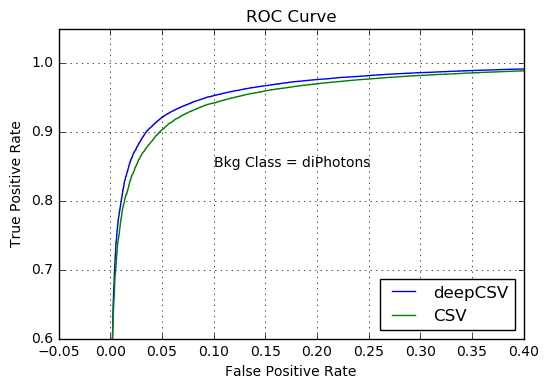

In [36]:
plt.clf()
for i in range(0,len(labels)):
    plt.plot(fpr_dipho_all[i], tpr_dipho_all[i], lw=1, label=labels[i])


plt.xlim([-0.05, 0.4])
plt.ylim([0.6, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.text(0.1,0.85, 'Bkg Class = diPhotons')
plt.grid()
outString = "comparison_diphotons_CSV"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".pdf")
plt.show()

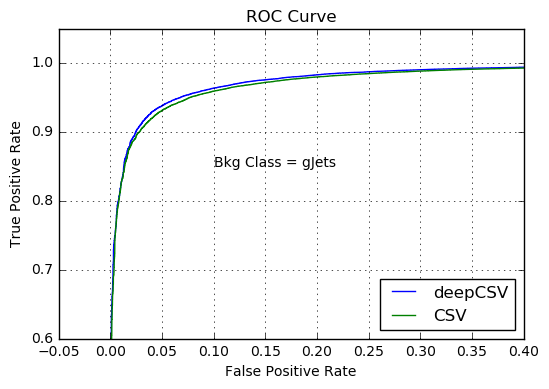

In [37]:
for i in range(0,len(labels)):
    plt.plot(fpr_gJets_all[i], tpr_gJets_all[i], lw=1, label=labels[i])


plt.xlim([-0.05, 0.4])
plt.ylim([0.6, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.text(0.1,0.85, 'Bkg Class = gJets')
plt.grid()
outString = "comparison_gJets_CSV"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".pdf")
plt.show()

In [67]:
#Compare the performance :

points = [0.80,0.85,0.90,0.95]

for point in points:
    rejections_gJets = []
    rejections_dipho = []
    for i in range(0,2):
        rej_dipho = fpr_dipho_all[i][np.argwhere(tpr_dipho_all[i]>point)[0]]
        print labels[i],' for diphotons : sig. eff. = %.2f , bkg. rej. = %.3f'%(point,rej_dipho)
        rejections_dipho.append(rej_dipho)
    improvement = (rejections_dipho[0]-rejections_dipho[1])/rejections_dipho[1]*100.
    print 'improvement vs CSV : %.3f'%improvement
    for i in range(0,2):
        rej_gJets = fpr_gJets_all[i][np.argwhere(tpr_gJets_all[i]>point)[0]]
        print labels[i],' for gJets : sig. eff. = %.2f , bkg. rej. = %.3f'%(point,rej_gJets)
        rejections_gJets.append(rej_gJets)
    improvement = (rejections_gJets[0]-rejections_gJets[1])/rejections_gJets[1]*100.
    print 'improvement vs CSV : %.3f'%improvement
    print 

deepCSV  for diphotons : sig. eff. = 0.80 , bkg. rej. = 0.011
CSV  for diphotons : sig. eff. = 0.80 , bkg. rej. = 0.014
improvement vs CSV : -22.915
deepCSV  for gJets : sig. eff. = 0.80 , bkg. rej. = 0.008
CSV  for gJets : sig. eff. = 0.80 , bkg. rej. = 0.008
improvement vs CSV : -5.503

deepCSV  for diphotons : sig. eff. = 0.85 , bkg. rej. = 0.018
CSV  for diphotons : sig. eff. = 0.85 , bkg. rej. = 0.025
improvement vs CSV : -27.523
deepCSV  for gJets : sig. eff. = 0.85 , bkg. rej. = 0.013
CSV  for gJets : sig. eff. = 0.85 , bkg. rej. = 0.014
improvement vs CSV : -4.549

deepCSV  for diphotons : sig. eff. = 0.90 , bkg. rej. = 0.035
CSV  for diphotons : sig. eff. = 0.90 , bkg. rej. = 0.048
improvement vs CSV : -27.375
deepCSV  for gJets : sig. eff. = 0.90 , bkg. rej. = 0.025
CSV  for gJets : sig. eff. = 0.90 , bkg. rej. = 0.028
improvement vs CSV : -12.601

deepCSV  for diphotons : sig. eff. = 0.95 , bkg. rej. = 0.093
CSV  for diphotons : sig. eff. = 0.95 , bkg. rej. = 0.120
improveme

array([  4.40719956e-05,   8.87963417e-05,   1.10859903e-04, ...,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00])